In [1]:
import stability_functions as sf
import numpy as np
from numpy.random import normal, seed, uniform
import os
import time
import sys
import rebound
import mr_forecast as mr
import numpy.random as rd
import radvel
import corner
import copy
import scipy
from scipy.optimize import curve_fit
import pandas as pd
from scipy import optimize
from radvel.plot import orbit_plots
import random
import dill
import sys
sys.path.append("../spock")
from spock import StabilityClassifier
import dask.dataframe as dd
from celmech import Andoyer
from multiprocessing import Pool
# plotting
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('paper.mplstyle')
# %matplotlib inline

/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/radvel/gp.py:33: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  Try installing celerite using 'pip install celerite'", ImportWarning)


In [2]:
std_out_holder = sys.__stdout__

def gaussian(x, a, mean, sigma):
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2)))

def quantile_1D(data, weights, quantile):
    ind_sorted = np.argsort(data)
    sorted_data = data[ind_sorted]
    sorted_weights = weights[ind_sorted]
    Sn =  np.array(np.cumsum(sorted_weights))
    Pn = (Sn-0.5*sorted_weights)/Sn[-1]
    return np.interp(quantile, Pn, sorted_data)

# Convenient function for plotting fits
def plot_results(like):
    ti = np.linspace(np.min(t), np.max(t), 1000)
    fig = plt.gcf()
    plt.errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    plt.plot(ti, like.model(ti))
    plt.xlabel('Time')
    plt.ylabel('RV')
    plt.draw()
    
def create_hist(label, show_quantiles=True, label2="", xlabel=""):
    
    print("working on " + label)
    if label2 == "":
        label2=label
    plt.figure(figsize=(8,4.5))
    n_bins=50
    plt.hist(df[label], density=True, bins=n_bins, alpha=0.6)
    plt.hist(df[label], density=True, bins=n_bins, alpha=0.6, weights=df["probstability"])
    # plt.hist(df[label], n_bins, density=True, histtype='step', cumulative=True)
    # plt.hist(df[label], n_bins, density=True, histtype='step', cumulative=True, weights=df["probstability"])
    plt.title(system_name + label2, size=30)
    plt.xlabel(xlabel, size=20)
    left, right = plt.xlim()  # return the current xlim
    left = 0
    plt.xlim(left, right)
    print("\n")
    std1 = np.std(df[label])
    weight_mean = np.average(df[label], weights=df["probstability"])
    std2 = np.sqrt(np.average((df[label]-weight_mean)**2, weights=df["probstability"]))
    print("std before: %f"%(std1))
    print("std after: %f"%(std2))
    print("factor of %f smaller"%(std1/std2))
    
    quant1 = np.quantile(df[label], 0.16)
    quant2 = np.quantile(df[label], 0.84)
    quant3 = quantile_1D(df[label], df["probstability"], 0.16)
    quant4 = quantile_1D(df[label], df["probstability"], 0.84)
    sigma1 = (quant2 - quant1) / 2
    sigma2 = (quant4 - quant3) / 2
    print("\"sigma\" before: %f"%(sigma1))
    print("\"sigma\" after: %f"%(sigma2))
    print("factor of %f smaller"%(sigma1/sigma2))
    if show_quantiles:
        plt.axvline(x=quant1, color="C0")
        plt.axvline(x=quant2, color="C0")
        plt.axvline(x=quant3, color="C1")
        plt.axvline(x=quant4, color="C1")
        
        kde = scipy.stats.gaussian_kde(df[label])
        xs = np.linspace(left, right, 1000)
        ys = kde(xs) + kde(-xs)
        popt1, pcov = curve_fit(gaussian, xs, ys, [0.3, 1, 3])
        print("Gaussian fit std before: ", popt1[2])
#         plt.plot(xs, ys, color="C0")
        plt.plot(xs, gaussian(xs, *popt1), color="C0")
        
        kde = scipy.stats.gaussian_kde(df[label], weights=df["probstability"])
        ys = kde(xs) + kde(-xs)
        popt2, pcov = curve_fit(gaussian, xs, ys, [0.3, 1, 3])
        print("Gaussian fit std after: ", popt2[2])
#         plt.plot(xs, ys, color="C1")
#         plt.plot(xs, gaussian(xs, *popt2), color="C1")
        
        print("factor of %f smaller\n"%(popt1[2]/popt2[2]))
        
    plt.savefig(notebook_name + label + "_weight_hist.png", bbox_inches="tight")

def create_hist2(label, show_quantiles=True, label2="", xlabel="", max_x=np.inf):
    
    print("working on " + label + "\n")
    if label2 == "":
        label2=label
    plt.figure(figsize=(8,4.5))
    n_bins=50
    plt.hist(df[label], density=True, bins=n_bins, alpha=0.6)
    plt.hist(df2[label][df2[label] < max_x], density=True, bins=n_bins, alpha=0.6)
    # plt.hist(df[label], n_bins, density=True, histtype='step', cumulative=True)
    # plt.hist(df[label], n_bins, density=True, histtype='step', cumulative=True, weights=df["probstability"])
    plt.title(system_name + label2, size=30)
    plt.xlabel(xlabel, size=20)
    left, right = plt.xlim()  # return the current xlim
    left = 0
    right = np.minimum(right, max_x)
    plt.xlim(left, right)
    print("\n")
    std1 = np.std(df[label])
    std2 = np.std(df2[label])
    print("std before: %f\n"%(std1))
    print("std after: %f\n"%(std2))
    print("factor of %f smaller\n"%(std1/std2))
    
    quant1 = np.quantile(df[label], 0.16)
    quant2 = np.quantile(df[label], 0.84)
    quant3 = np.quantile(df2[label], 0.16)
    quant4 = np.quantile(df2[label], 0.84)
    sigma1 = (quant2 - quant1) / 2
    sigma2 = (quant4 - quant3) / 2
    print("\"sigma\" before: %f\n"%(sigma1))
    print("\"sigma\" after: %f\n"%(sigma2))
    print("factor of %f smaller\n"%(sigma1/sigma2))
    if show_quantiles:
        plt.axvline(x=quant1, color="C0")
        plt.axvline(x=quant2, color="C0")
        plt.axvline(x=quant3, color="C1")
        plt.axvline(x=quant4, color="C1")
        
        kde = scipy.stats.gaussian_kde(df[label])
        xs = np.linspace(left, right, 1000)
        ys = kde(xs) + kde(-xs)
        popt1, pcov = curve_fit(gaussian, xs, ys, [0.3, 1, 3])
        print("Gaussian fit std before: ", popt1[2], "\n")
#         plt.plot(xs, ys, color="C0")
#         plt.plot(xs, gaussian(xs, *popt1), color="C0")
        
        inds = np.sort(np.random.choice(range(len(df2)), size=5000, replace=False))
        kde = scipy.stats.gaussian_kde(df2[label][inds])
        ys = kde(xs) + kde(-xs)
        popt2, pcov = curve_fit(gaussian, xs, ys, [0.3, 1, 3])
        print("Gaussian fit std after: ", popt2[2], "\n")
#         plt.plot(xs, ys, color="C1")
#         plt.plot(xs, gaussian(xs, *popt2), color="C1")
        
        print("factor of %f smaller\n"%(popt1[2]/popt2[2]))

    plt.savefig(notebook_name + "%d_"%(err_ind) + label + "_mcmc_hist.png", bbox_inches="tight")
    
def myPriorFunc(inp_list):

    prob = 1

    for i in range(3):
        secosw = inp_list[labels.index("secosw%d"%(i+1))]
        sesinw = inp_list[labels.index("sesinw%d"%(i+1))]
        e = secosw * secosw + sesinw * sesinw
        if e > 1:
            return -np.inf
        P = inp_list[labels.index("per%d"%(i+1))] / sf.days_p_year
        k = inp_list[labels.index("k%d"%(i+1))]
        m = sf.mass_from_VSA(P, Mstar, k, e, np.pi/2)
        prob *= (prior_ms_small[i](m) + prior_ms_small[i](-m)) * (prior_es_small[i](e) + prior_es_small[i](-e))

    return np.log(prob)

def prep_df(df2):
    df = df2.copy()
#     df = df.drop(columns="jit")
    df = df.drop(columns="lnprobability")
    for i in range(1,4):
        df["e%d"%i] = df["secosw%d"%i] * df["secosw%d"%i] + df["sesinw%d"%i] * df["sesinw%d"%i]
#         df["e%d"%i][df["e%d"%i] > 1] = 0
        df["m%d"%i] = sf.mass_from_VSA(df["per%d"%i] / days_p_year, Mstar, df["k%d"%i].abs(), df["e%d"%i], np.pi/2)
        df = df.drop(columns="k%d"%i)
        df = df.drop(columns="per%d"%i)
        df = df.drop(columns="tc%d"%i)
        df = df.drop(columns="secosw%d"%i)
        df = df.drop(columns="sesinw%d"%i)
    df = df[labels_base]
    return df

notebook_name = "figs/K431_density_"
system_name = "K431 "

seconds_p_day = 86400
days_p_year = 365.25
meters_p_AU = 149597870700
earth_mass_2_solar_mass = 0.000003003
year_p_reboundtime = 1 / (2 * np.pi)

df = pd.read_csv("K431_uni_dens.csv")
df["m1"] /= sf.earth_mass_2_solar_mass
df["m2"] /= sf.earth_mass_2_solar_mass
df["m3"] /= sf.earth_mass_2_solar_mass
df["m1+m2"] = df["m1"] + df["m2"]
df["m2+m3"] = df["m2"] + df["m3"]
df["total m"] = df["m1"] + df["m2"] + df["m3"]
scores = 2 * df["probstability"]
n = len(scores)
# effective sample size using eq 9.13 https://statweb.stanford.edu/~owen/mc/Ch-var-is.pdf
effective_sample_size = n * np.mean(scores) ** 2 / np.mean(scores ** 2)
print(effective_sample_size)
print(n)
print(effective_sample_size / n)

sim_nums = np.array([10, 82, 199, 55, 101, 84, 127, 2050, 261, 100, 190, 218])
sim_num = sim_nums[0]

system = "K431"
out_dir = os.getcwd()+"/output/"+system+"/"
name = out_dir+system+"_start_"+str(sim_num)+".bin"

print("simulation archive:", name)
sim = rebound.SimulationArchive(name)[0]

n_meas = 50
t_rb = 0.75 * np.sort(rd.rand(n_meas))
syn_rv_base = sf.rebound_rvs(t_rb, rebound.SimulationArchive(name)[0])
ti_rb = np.linspace(np.min(t_rb), np.max(t_rb), 1000)
syn_rv_no_noise = sf.rebound_rvs(ti_rb, rebound.SimulationArchive(name)[0])
t = t_rb * days_p_year
ti = ti_rb * days_p_year

errs = np.array([30, 10, 3, 1, 0.3, 0.1])
jitter = 0.0
stellar = jitter * rd.randn(n_meas)

print("jitter value:", jitter)

Ps = np.array([sim.particles[i+1].P for i in range(3)]) * (days_p_year * year_p_reboundtime)
es = np.array([sim.particles[i+1].e for i in range(3)])
Mstar = sim.particles[0].m
ms = np.array([sim.particles[i+1].m for i in range(3)]) / earth_mass_2_solar_mass
incs = np.array([sim.particles[i+1].inc for i in range(3)]) + np.pi/2
og_Ks = sf.VSA(Ps / days_p_year, Mstar, ms, es, incs)
Ks = np.copy(og_Ks)

omegas = np.array([sim.particles[i+1].omega for i in range(3)])
print("og Ks:", og_Ks)
print("initial Ks:", Ks)

truths = list(es)
truths.extend([sim.particles[i+1].m / earth_mass_2_solar_mass * np.cos(sim.particles[i+1].inc) for i in range(3)])
    
labels_base = ["e1","e2", "e3", "m1", "m2", "m3"]

806.8470104677044
10000
0.08068470104677045
simulation archive: /storage/work/c/cjg66/Dan_research/Stability-Priors/output/K431/K431_start_10.bin


RuntimeError: Cannot read binary file. Check filename and file contents.

working on m1


std before: 1.749447
std after: 1.569453
factor of 1.114686 smaller
"sigma" before: 1.699540
"sigma" after: 1.536579
factor of 1.106054 smaller
Gaussian fit std before:  2.4535597413834886
Gaussian fit std after:  3.691318492370617
factor of 0.664684 smaller

working on m2


std before: 1.941765
std after: 1.962992
factor of 0.989186 smaller
"sigma" before: 1.719318
"sigma" after: 1.687904
factor of 1.018611 smaller
Gaussian fit std before:  2.86411337865022
Gaussian fit std after:  4.056443864487239
factor of 0.706065 smaller

working on m3


std before: 3.102275
std after: 2.318318
factor of 1.338158 smaller
"sigma" before: 3.065462
"sigma" after: 2.104695
factor of 1.456488 smaller
Gaussian fit std before:  4.56176683389485
Gaussian fit std after:  7.824325460453781
factor of 0.583024 smaller

working on m1+m2


std before: 2.602214
std after: 2.569432
factor of 1.012758 smaller
"sigma" before: 2.476197
"sigma" after: 2.391890
factor of 1.035247 smaller
Gaussian fit 

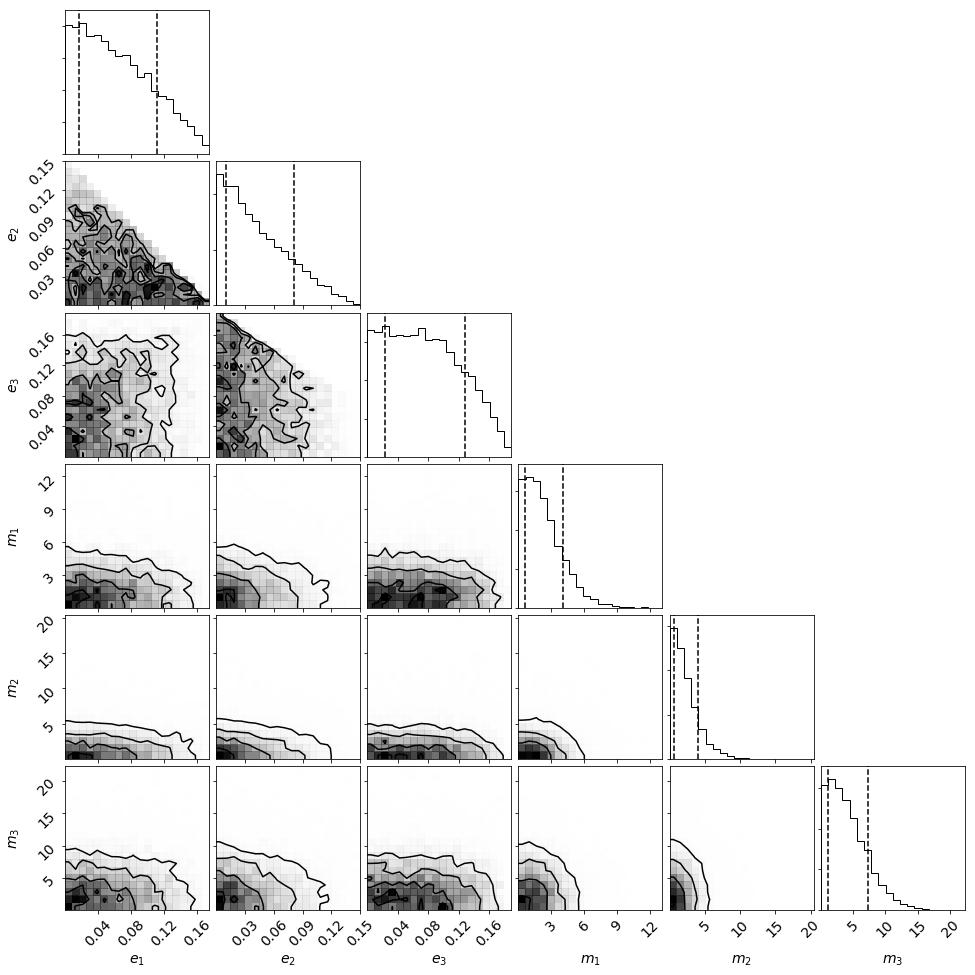

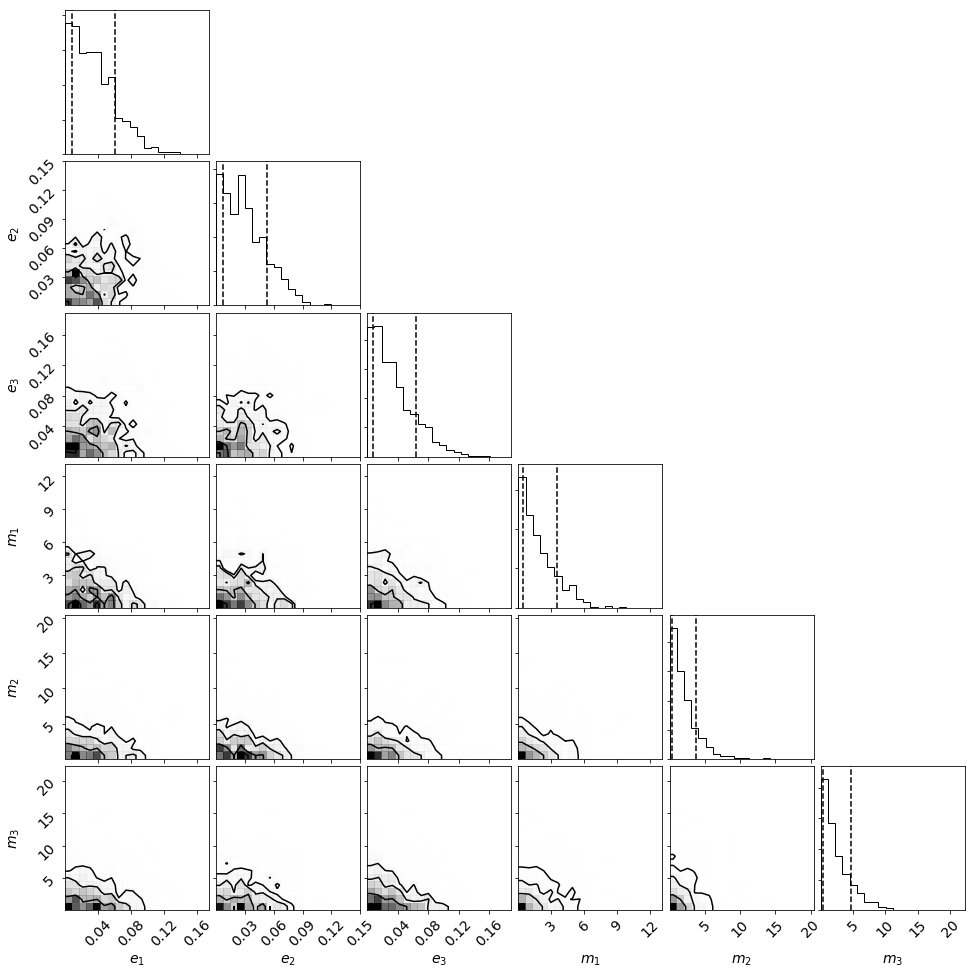

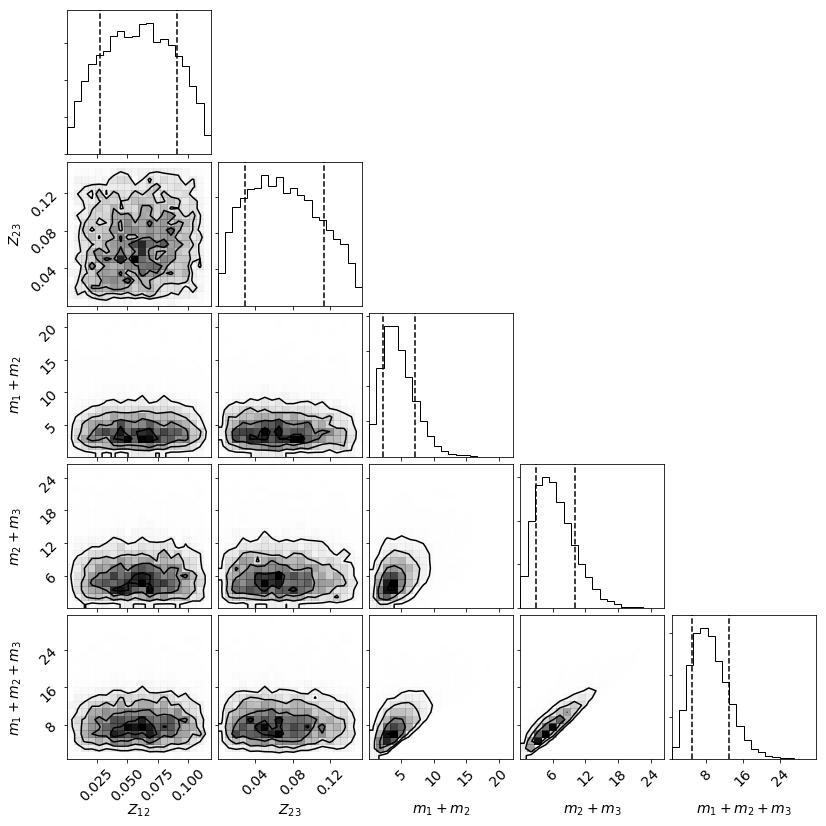

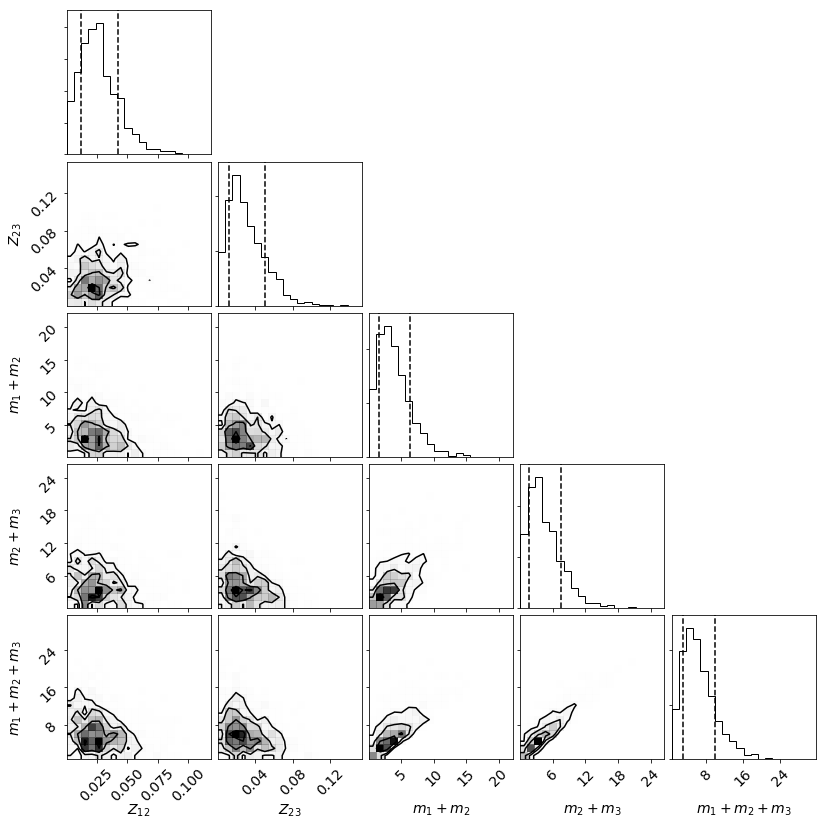

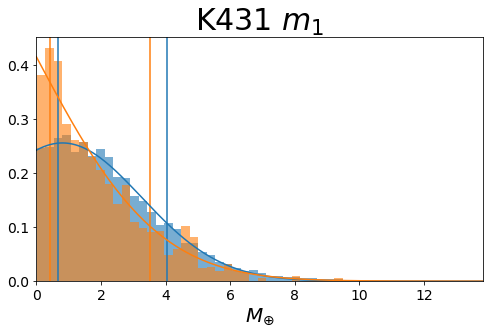

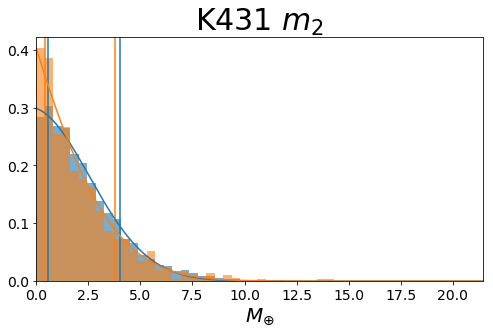

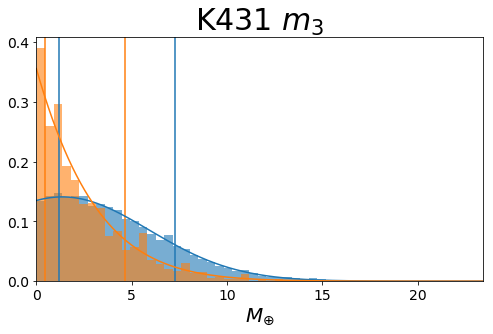

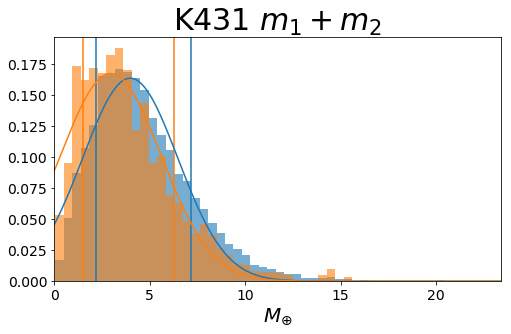

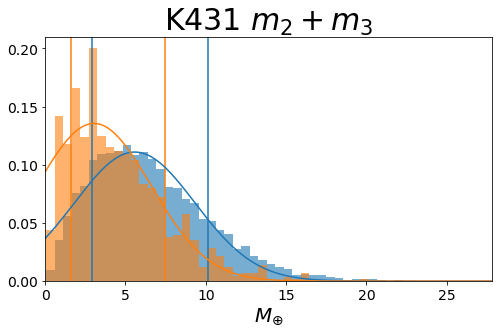

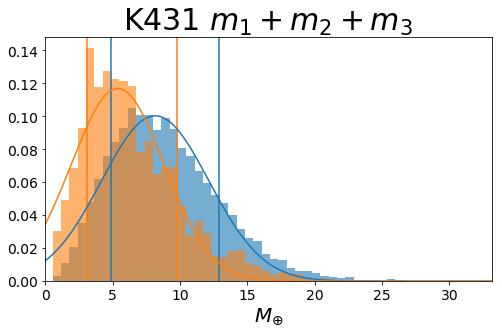

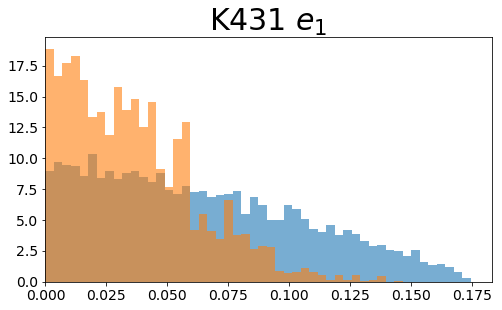

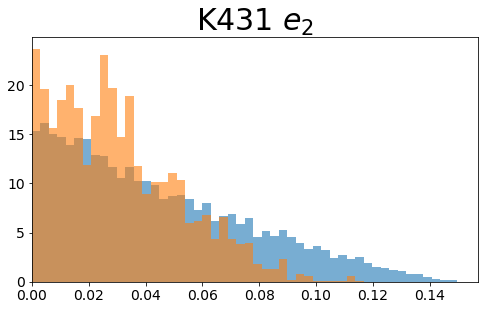

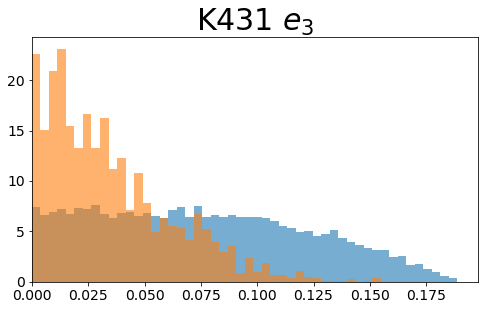

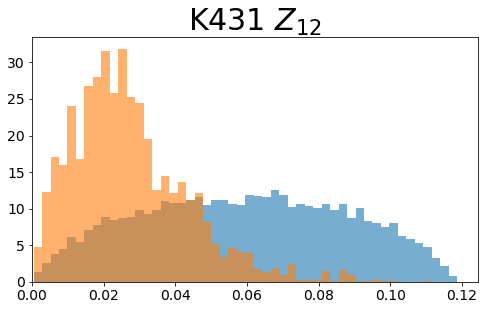

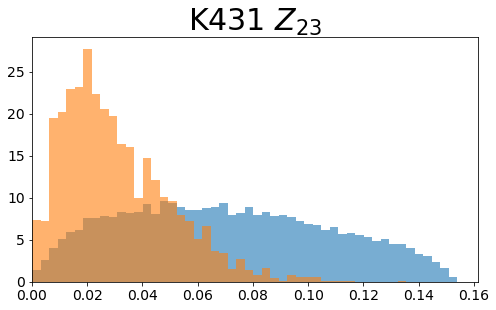

In [5]:
%%time
labels2 = [r"$e_1$", r"$e_2$", r"$e_3$", r"$m_1$", r"$m_2$", r"$m_3$"]
fig = corner.corner(df[labels_base], labels=labels2, quantiles=[0.16,0.84], plot_datapoints=False)
plt.savefig(notebook_name + "physical_corner_noweight.png", bbox_inches="tight")
fig = corner.corner(df[labels_base], labels=labels2, quantiles=[0.16,0.84], plot_datapoints=False, weights=df["probstability"])
plt.savefig(notebook_name + "physical_corner_weight.png", bbox_inches="tight")

labels_mod = ["Z12", "Z23", "m1+m2", "m2+m3", "total m"]
labels3 = [r"$Z_{12}$", r"$Z_{23}$", r"$m_1 + m_2$", r"$m_2 + m_3$", r"$m_1 + m_2 + m_3$"]
fig = corner.corner(df[labels_mod], labels=labels3, quantiles=[0.16,0.84], plot_datapoints=False)
plt.savefig(notebook_name + "param_corner_noweight.png", bbox_inches="tight")
fig = corner.corner(df[labels_mod], labels=labels3, quantiles=[0.16,0.84], plot_datapoints=False, weights=df["probstability"])
plt.savefig(notebook_name + "param_corner_weight.png", bbox_inches="tight")

create_hist("m1", label2=r"$m_1$", xlabel=r"$M_{\oplus}$")
create_hist("m2", label2=r"$m_2$", xlabel=r"$M_{\oplus}$")
create_hist("m3", label2=r"$m_3$", xlabel=r"$M_{\oplus}$")

create_hist("m1+m2", label2=r"$m_1 + m_2$", xlabel=r"$M_{\oplus}$")
create_hist("m2+m3", label2=r"$m_2 + m_3$", xlabel=r"$M_{\oplus}$")
create_hist("total m", label2=r"$m_1 + m_2 + m_3$", xlabel=r"$M_{\oplus}$")

create_hist("e1", show_quantiles=False, label2=r"$e_1$")
create_hist("e2", show_quantiles=False, label2=r"$e_2$")
create_hist("e3", show_quantiles=False, label2=r"$e_3$")

create_hist("Z12", show_quantiles=False, label2=r"$Z_{12}$")
create_hist("Z23", show_quantiles=False, label2=r"$Z_{23}$")

In [ ]:
%%time
for err_ind in range(len(errs)):
# for err_ind in range(1):
    sys.stdout = open(notebook_name + "%d_notes.txt"%err_ind, "w")
    
    errval = errs[err_ind]
    
    print("working on err_ind %d\n"%err_ind)
    print("with an error value of %f m/s\n"%errval)
    
    syn_rv = syn_rv_base + rd.randn(n_meas) * errval + stellar
    
    params = radvel.Parameters(3, basis='per tc secosw sesinw k')
    params['per1'] = radvel.Parameter(value=Ps[0])
    params['tc1'] = radvel.Parameter(value= 2454971.03562)
    params['secosw1'] = radvel.Parameter(value=np.sqrt(es[0]) * np.cos(omegas[0]))
    params['sesinw1'] = radvel.Parameter(value=np.sqrt(es[0]) * np.sin(omegas[0]))
    params['k1'] = radvel.Parameter(value=Ks[0])

    params['per2'] = radvel.Parameter(value=Ps[1])
    params['tc2'] = radvel.Parameter(value=2454973.1707)
    params['secosw2'] = radvel.Parameter(value=np.sqrt(es[1]) * np.cos(omegas[1]))
    params['sesinw2'] = radvel.Parameter(value=np.sqrt(es[1]) * np.sin(omegas[1]))
    params['k2'] = radvel.Parameter(value=Ks[1])

    params['per3'] = radvel.Parameter(value=Ps[2])
    params['tc3'] = radvel.Parameter(value=2454970.47509)
    params['secosw3'] = radvel.Parameter(value=np.sqrt(es[2]) * np.cos(omegas[2]))
    params['sesinw3'] = radvel.Parameter(value=np.sqrt(es[2]) * np.sin(omegas[2]))
    params['k3'] = radvel.Parameter(value=Ks[2])

    # params['dvdt'] = radvel.Parameter(value=0)
    # params['curv'] = radvel.Parameter(value=0)

    rv_mod = radvel.RVModel(params)
    
    like_syn = radvel.likelihood.RVLikelihood(rv_mod, t, syn_rv, np.zeros(t.size)+errval)
    like_syn.params['gamma'] = radvel.Parameter(value=0)
    like_syn.params['jit'] = radvel.Parameter(value=jitter)

    like_syn.params['jit'].vary = False # Don't vary jitter
    # like_syn.params['k1'].vary = False # Don't vary period
    # like_syn.params['k2'].vary = False # Don't vary period
    # like_syn.params['k3'].vary = False # Don't vary period
    # like_syn.params['per1'].vary = False # Don't vary period
    # like_syn.params['per2'].vary = False # Don't vary period
    # like_syn.params['per3'].vary = False # Don't vary period
    like_syn.params['dvdt'].vary = False # Don't vary dvdt
    like_syn.params['curv'].vary = False # Don't vary curvature
    like_syn.params['gamma'].vary = False # Don't vary gamma
    print(like_syn, "\n")
    
    # Plot initial model
    plot_results(like_syn)
    plt.plot(ti, syn_rv_no_noise)
    plt.savefig(notebook_name + "%d_beforeMLE.png"%err_ind, bbox_inches="tight")
    plt.close(fig="all")
    
    res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='L-BFGS-B')
    # print(res)
    print(like_syn, "\n")
    plot_results(like_syn) # plot best fit model
    plt.plot(ti, syn_rv_no_noise)
    plt.savefig(notebook_name + "%d_afterMLE.png"%err_ind, bbox_inches="tight")

    post = radvel.posterior.Posterior(like_syn)

    post.priors += [radvel.prior.Gaussian("per1", 6.80252171, 7.931e-05)]
    post.priors += [radvel.prior.Gaussian("per2", 8.70337044, 9.645e-05)]
    post.priors += [radvel.prior.Gaussian("per3", 11.9216214, 0.0001182)]

    labels = [k for k in post.params.keys() if post.params[k].vary]

    prior_ms = [scipy.stats.gaussian_kde(df["m1"]), scipy.stats.gaussian_kde(df["m2"]), scipy.stats.gaussian_kde(df["m3"])]
    prior_es = [scipy.stats.gaussian_kde(df["e1"]), scipy.stats.gaussian_kde(df["e2"]), scipy.stats.gaussian_kde(df["e3"])]

    inds = np.sort(np.random.choice(range(len(df)), size=4000, replace=False))
    prior_ms_small = [scipy.stats.gaussian_kde(df["m1"][inds]), scipy.stats.gaussian_kde(df["m2"][inds]), scipy.stats.gaussian_kde(df["m3"][inds])]
    prior_es_small = [scipy.stats.gaussian_kde(df["e1"][inds]), scipy.stats.gaussian_kde(df["e2"][inds]), scipy.stats.gaussian_kde(df["e3"][inds])]

    post.priors += [radvel.prior.UserDefinedPrior(labels, myPriorFunc, 'Eccentricty and mass prior')]
    # post.priors += [radvel.prior.EccentricityPrior(3)]

    print("Before fitting\n")
    print(post, "\n")
    
    # res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Nelder-Mead' )
    res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='L-BFGS-B')
    # plot_results(post.likelihood)
    plt.savefig(notebook_name + "%d_afterpriors.png"%err_ind, bbox_inches="tight")
    print("After fitting\n")
    print(post, "\n")
    
    RVPlot = orbit_plots.MultipanelPlot(post)
    RVPlot.plot_multipanel()
    # plt.show()
    plt.savefig(notebook_name + "%d_afterpriors_multi.png"%err_ind, bbox_inches="tight")
    # plt.close(fig="all")
    
    # df = radvel.mcmc(post) # amount of steps = nrun * 8 * nwalkers ?
    df3 = radvel.mcmc(post, nrun=10000) # amount of steps = nrun * 8 * nwalkers ?, default nrun is 10000, default nwalkers is 50?
    df3.to_pickle(notebook_name + "%d_mcmc.pkl"%err_ind)
    
    # fig = corner.corner(df3[labels], labels=labels, quantiles=[0.16,0.84], plot_datapoints=False)
    # plt.savefig("figs/corner_K431_%d.png"%err_ind, bbox_inches="tight")

    df2 = prep_df(df3)

    labels = list(df2.columns)
    fig = corner.corner(df2, labels=labels2, truths=truths, quantiles=[0.16,0.84], plot_datapoints=False)
    plt.savefig(notebook_name + "%d_physical_corner.png"%err_ind, bbox_inches="tight")
    
    df2["m1+m2"] = df2["m1"] + df2["m2"]
    df2["m2+m3"] = df2["m2"] + df2["m3"]
    df2["total m"] = df2["m1"] + df2["m2"] + df2["m3"]
    
    create_hist2("m1", label2=r"$m_1$", xlabel=r"$M_{\oplus}$")
    create_hist2("m2", label2=r"$m_2$", xlabel=r"$M_{\oplus}$")
    create_hist2("m3", label2=r"$m_3$", xlabel=r"$M_{\oplus}$")
    
    create_hist2("m1+m2", label2=r"$m_1 + m_2$", xlabel=r"$M_{\oplus}$")
    create_hist2("m2+m3", label2=r"$m_2 + m_3$", xlabel=r"$M_{\oplus}$")
    create_hist2("total m", label2=r"$m_1 + m_2 + m_3$", xlabel=r"$M_{\oplus}$")
    
    xs = np.linspace(0,1,1000)
    create_hist2("e1", show_quantiles=False, label2=r"$e_1$")
    create_hist2("e2", show_quantiles=False, label2=r"$e_2$")
    create_hist2("e3", show_quantiles=False, label2=r"$e_3$")
    
    sys.stdout.close()

sys.stdout = std_out_holder

In [11]:
print(4)

In [13]:
df3.to_pickle(notebook_name + "%d_mcmc.pkl"%err_ind)